In [54]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.cross_validation import cross_val_score
from sklearn import clone
import math

import lightgbm as lgb
import xgboost as xgb
import numpy as np
import pandas as pd
import warnings
from bayes_opt import BayesianOptimization
import random
from itertools import combinations
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline


train = pd.read_csv('/Users/adodd202/Documents/Bootcamp_Spring2018/HousingPricesML/Data/train_120feats_Dense_OutlierFree_LogTransform.csv')
test = pd.read_csv('/Users/adodd202/Documents/Bootcamp_Spring2018/HousingPricesML/Data/test_119feats_Dense_OutlierFree_LogTransform.csv')

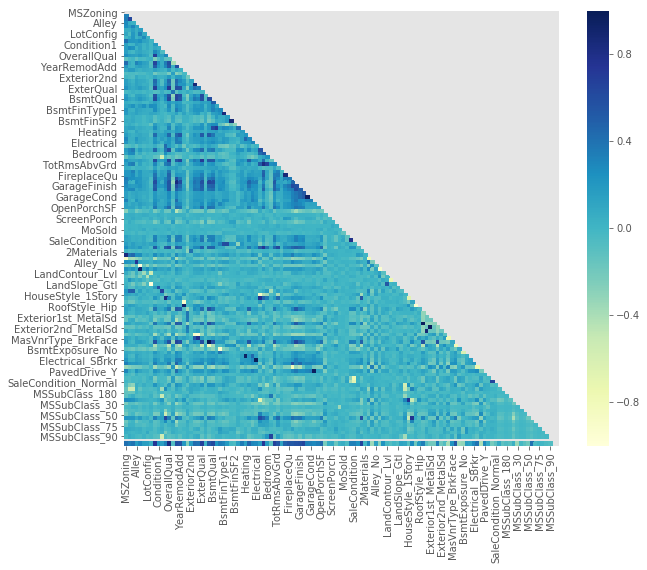

In [55]:
corr = train.corr()
f, ax = plt.subplots(figsize=(10, 8))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, cmap="YlGnBu",
           square=True, ax=ax)
plt.show()

In [56]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
top_corr = get_top_abs_correlations(train, 5000)


Top Absolute Correlations


In [68]:
l1 = [['MSZoning', 0.40673738911868496],
 ['LotFrontage', 0.33745320971276804],
 ['LotArea', 0.39368286839976796],
 ['Alley', 0.17598289072990425],
 ['LotShape', 0.28158050218085795],
 ['LandContour', 0.1626505801315844],
 ['LotConfig', 0.14920761088282239],
 ['LandSlope', 0.049947024264353344],
 ['Neighborhood', 0.73716124742403955],
 ['Condition1', 0.21196610551007292],
 ['BldgType', 0.15404147871491883],
 ['HouseStyle', 0.32193189704368619],
 ['OverallQual', 0.81443090607974877],
 ['OverallCond', -0.06527952024567886],
 ['YearBuilt', 0.59177251034094469],
 ['YearRemodAdd', 0.55718347551961855],
 ['RoofStyle', 0.20208527881061591],
 ['Exterior1st', -0.27096509304528654],
 ['Exterior2nd', 0.18387335207702332],
 ['MasVnrType', 0.4371631756804164],
 ['MasVnrArea', 0.41128998643097775],
 ['ExterQual', 0.67822791545817573],
 ['ExterCond', 0.03056008688030859],
 ['Foundation', 0.52700971237534144],
 ['BsmtQual', 0.63114107150451715],
 ['BsmtCond', 0.22189528773562864],
 ['BsmtExposure', 0.35511521635315463],
 ['BsmtFinType1', 0.3228869989642974],
 ['BsmtFinSF1', 0.19089917114081709],
 ['BsmtFinType2', -0.020178722690092878],
 ['BsmtFinSF2', -0.048590324745011272],
 ['BsmtUnfSF', 0.1536174048051446],
 ['TotalBsmtSF', 0.36344354516251975],
 ['Heating', 0.15938413391873982],
 ['HeatingQC', 0.46392786474156322],
 ['CentralAir', 0.31247965322535637],
 ['Electrical', 0.2883272332282461],
 ['2ndFlrSF', 0.17941955928373479],
 ['GrLivArea', 0.73531899847643356],
 ['Bedroom', 0.19150900622247349],
 ['Kitchen', -0.1085023437022859],
 ['KitchenQual', 0.66692549594876549],
 ['TotRmsAbvGrd', 0.5421619383298063],
 ['Functional', 0.1306250152257912],
 ['Fireplaces', 0.48387297897760051],
 ['FireplaceQu', 0.5420643409033632],
 ['GarageType', 0.53598231693790088],
 ['GarageYrBlt', 0.56928451649895917],
 ['GarageFinish', 0.59176049973984701],
 ['GarageArea', 0.65186740938869092],
 ['GarageQual', 0.33698105064929618],
 ['GarageCond', 0.33043466210024897],
 ['PavedDrive', 0.2909667426167129],
 ['WoodDeckSF', 0.34436307350632073],
 ['OpenPorchSF', 0.45234226438305558],
 ['EnclosedPorch', -0.22210542523869622],
 ['3SsnPorch', 0.062864240312897252],
 ['ScreenPorch', 0.088582686280813672],
 ['Fence', -0.1621258300605514],
 ['MiscFeature', 0.030455883195138114],
 ['MoSold', 0.058408669546247287],
 ['YrSold', -0.03999409536853616],
 ['SaleType', 0.33199842917152772],
 ['SaleCondition', 0.32993095037796105],
 ['BsmtBath', 0.24494965126610485],
 ['Bath', 0.65249384232358565],
 ['2Materials', 0.0017656803623169375],
 ['MSZoning_RL', 0.29696059207391751],
 ['MSZoning_RM', -0.34837911565106688],
 ['Alley_No', 0.14453753911304945],
 ['LotShape_Reg', -0.28158050218085795],
 ['LotShape_IR1', 0.23731658808890538],
 ['LandContour_Lvl', -0.022603862375686977],
 ['LotConfig_Inside', -0.077768014413224062],
 ['LotConfig_Corner', -0.0074038715188024318],
 ['LandSlope_Gtl', -0.049947024264353317],
 ['Condition1_Norm', 0.13021757410133694],
 ['BldgType_1Fam', 0.096775917787685115],
 ['HouseStyle_1Story', -0.079010909744127555],
 ['HouseStyle_2Story', 0.26642298029012823],
 ['RoofStyle_Gable', -0.18246405435408647],
 ['RoofStyle_Hip', 0.19267701360261744],
 ['Exterior1st_VinylSd', 0.33724290692635855],
 ['Exterior1st_HdBoard', -0.091977507060091487],
 ['Exterior1st_MetalSd', -0.18930385030977914],
 ['Exterior1st_Wd Sdng', -0.19689743811994659],
 ['Exterior2nd_VinylSd', 0.33463875959832717],
 ['Exterior2nd_MetalSd', -0.18332300717228825],
 ['Exterior2nd_HdBoard', -0.063460855745648012],
 ['MasVnrType_None', -0.39100915511975148],
 ['MasVnrType_BrkFace', 0.22833479835271681],
 ['Foundation_PConc', 0.52619874058589899],
 ['Foundation_CBlock', -0.35138678652603955],
 ['BsmtExposure_No', -0.3195259498424034],
 ['BsmtExposure_Av', 0.15773136387627751],
 ['Heating_GasA', 0.12605125175347945],
 ['Electrical_SBrkr', 0.28664780198251827],
 ['GarageType_Attchd', 0.39887101205226333],
 ['GarageType_Detchd', -0.40831242376505728],
 ['PavedDrive_Y', 0.28804793502891346],
 ['MiscFeature_No', 0.071324024060375121],
 ['SaleType_WD', -0.21125631945927131],
 ['SaleCondition_Normal', -0.11551275986771997],
 ['MSSubClass_120', 0.083845223766082694],
 ['MSSubClass_160', -0.11908124549019543],
 ['MSSubClass_180', -0.057967556220531909],
 ['MSSubClass_190', -0.10154226824173261],
 ['MSSubClass_20', 0.041430140616392434],
 ['MSSubClass_30', -0.33818319936364172],
 ['MSSubClass_40', -0.022814401110779082],
 ['MSSubClass_45', -0.1088102200518543],
 ['MSSubClass_50', -0.18570230061238979],
 ['MSSubClass_60', 0.40308073164259711],
 ['MSSubClass_70', -0.036955980657062945],
 ['MSSubClass_75', 0.0075352150226983289],
 ['MSSubClass_80', -0.0068898351538840639],
 ['MSSubClass_85', -0.043485267093216116],
 ['MSSubClass_90', -0.069698145492671268],
    ['SalePrice', 1]]

print(type(np.abs(l1[0][1])))
l2 = []
j = 0
for i in l1:
    if np.abs(i[1]) > .35:
        l2.append(j)
    j+=1
print(l2)

<class 'numpy.float64'>
[0, 2, 8, 12, 14, 15, 19, 20, 21, 23, 24, 26, 32, 34, 38, 41, 42, 44, 45, 46, 47, 48, 49, 54, 65, 89, 91, 92, 97, 98, 112, 118]
